In [4]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import geopandas as gpd
import xgboost
import sys
from sklearn.preprocessing import LabelEncoder
import numpy as np
from math import * 
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.cluster import DBSCAN, OPTICS
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures

import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.style.use('dark_background')

from utils import plot_cluster, load_list, save_list, load_data, load_data_test


In [7]:
X, Y = load_data(add_knn_mean=True,
                 add_knn_concat=True,
                 add_dates=True,
                 add_polynomial=False,
                 add_fourier=True,
                 n_data_max=9999999999,
                 shuffle = True)

X_target = load_data_test(add_knn_mean=True,
                 add_knn_concat=True,
                 add_dates=True,
                 add_fourier=True,
                 n_data_max=99999999,
                 shuffle = False)

print(f'Datas containing NA loaded: {len(X[X.isna().any(axis = 1)])}')


Loading data...

Basic features lenght: 310006
knn mean features lenght: 310006
knn concat features lenght: 310006
Dates features lenght: 310006
Building Fourier coefficients...
Done
X_train and Y_train loaded.
Loading data...

Basic features lenght: 121704
knn mean features lenght: 121704
knn concat features lenght: 121704
Dates features lenght: 121704
Building Fourier coefficients...
Done
X_val loaded.
Datas containing NA loaded: 169


In [8]:
print(X.shape)
print(Y.shape)
print(X_target.shape)

(310006, 141)
(310006,)
(121704, 141)


In [9]:
print(list(X.columns))

['change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4', 'change_status_date5', 'diff1', 'diff2', 'diff3', 'diff4', 'year_date1', 'year_date2', 'year_date3', 'year_date4', 'year_date5', 'area', 'length', 'area/length**2', 'elongation', 'centroid_x', 'centroid_y', 'height', 'width', 'nb_points', 'diff_area', 'is_convex', 'centroid_dist', 'length/width', 'Dense Urban', 'Industrial', 'None', 'Rural', 'Sparse Urban', 'Urban Slum', 'Barren Land', 'Coastal', 'Dense Forest', 'Desert', 'Farms', 'Grass Land', 'Hills', 'Lakes', 'None.1', 'River', 'Snow', 'Sparse Forest', 'knn_mean_area', 'knn_mean_length', 'knn_mean_area/length**2', 'knn_mean_elongation', 'knn_mean_centroid_x', 'knn_mean_height', 'knn_mean_width', 'knn_mean_nb_points', 'knn_mean_centroid_dist', 'knn_mean_length/width', 'knn_mean_Dense Urban', 'knn_mean_Industrial', 'knn_mean_None', 'knn_mean_Rural', 'knn_mean_Sparse Urban', 'knn_mean_Urban Slum', 'knn_mean_Barren Land', 'knn_mean_Coastal', 'kn

In [16]:

# xgb = XGBClassifier()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 22)

print('Fitting...')
L_n = [700]
L_d = [2, 3, 4, 5, 10]
average = 'weighted'
L_train_score = list()
L_test_score = list()
L = list()

for n in L_n:
        # model = RandomForestClassifier(n_estimators=n,
        #                     max_depth=15,
        #                     min_samples_leaf=1,
        #                     min_samples_split=2,
        #                         )
        # model = GradientBoostingClassifier(n_estimators=n, 
        #                         )
        model = XGBClassifier( 
                        n_estimators = n,
                #       scale_pos_weight=1,
                #       learning_rate=0.01,  
                #       colsample_bytree = 0.4,
                #       subsample = 0.8,
                #       objective='binary:logistic', 
                #       reg_alpha = 0.3,
                        max_depth=8, 
                #       gamma=10,
                        use_label_encoder=False,
                      )
        
        eval_set = [(X_train, Y_train), (X_test, Y_test)]
        eval_metric = ["error"]
        model.fit(X_train, Y_train, 
                # eval_metric=eval_metric, 
                # eval_set=eval_set, 
                # verbose=False
                  )
        
        Y_pred          = model.predict(X_test)
        Y_pred_train    = model.predict(X_train)
        score_train = f1_score(Y_train, Y_pred_train, average = average)
        score_test = f1_score(Y_test, Y_pred, average = average)
        L_train_score.append(score_train)
        L_test_score.append(score_test)
        L.append(n)
        print(f"Train score: {score_train}")
        print(f"Test score: {score_test}")
        print()
        plt.clf()
        plt.plot(L, L_train_score, 'r')
        plt.plot(L, L_test_score, 'b')
        plt.ylim(bottom = 0, top = 1)
        model_final = model



Fitting...
[16:14:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [11]:
#IMPORTANCES OF FEATURES
importances = model.feature_importances_
for feature, imp in sorted(zip(X_train.columns, importances), key = lambda x: -x[1]):
    print(f'Importance of {feature}: {100*round(imp, 3)}%')

Importance of change_status_date5: 17.399999499320984%
Importance of change_status_date1: 5.499999970197678%
Importance of knn_mean_length/width: 2.500000037252903%
Importance of change_status_date2: 1.899999938905239%
Importance of area/length**2: 1.7000000923871994%
Importance of centroid_y: 1.600000075995922%
Importance of harm1_coeff1: 1.600000075995922%
Importance of knn_mean_area: 1.0999999940395355%
Importance of duration_to_reach5: 0.9999999776482582%
Importance of knn_mean_Desert: 0.9999999776482582%
Importance of knn_mean_area/length**2: 0.9999999776482582%
Importance of knn_mean_centroid_x: 0.9999999776482582%
Importance of centroid_dist: 0.8999999612569809%
Importance of old2: 0.8999999612569809%
Importance of 1th_nn_year_date4: 0.8999999612569809%
Importance of nb_points: 0.8999999612569809%
Importance of 1th_nn_centroid_x: 0.8999999612569809%
Importance of diff4: 0.8999999612569809%
Importance of height: 0.8999999612569809%
Importance of knn_mean_Industrial: 0.80000003799

In [ ]:
#FEATURE SELECTION USING CROSS VAL (too long)
from sklearn.feature_selection import RFECV
xgboost.set_config(verbosity=0)
xgb = model = XGBClassifier( 
                        n_estimators = 2,
                #       scale_pos_weight=1,
                #       learning_rate=0.01,  
                #       colsample_bytree = 0.4,
                #       subsample = 0.8,
                #       objective='binary:logistic', 
                #       reg_alpha = 0.3,
                        max_depth=2, 
                #       gamma=10,
                        use_label_encoder=False,
                      )
scorer = lambda estimator, x_test, y_true : f1_score(y_true, estimator.predict(x_test), average = 'weighted')
xgb_fs = RFECV(xgb, cv = 3, scoring = scorer)
N = 10000     
xgb_fs.fit(X_train[:N], np.array(Y_train[:N]))

In [418]:
K = 10
importances = np.zeros(shape = (X.shape[1], K))
for k in range(K):
        xgb = model = XGBClassifier( 
                        n_estimators = 10,
                        max_depth=5, 
                        use_label_encoder=False,
                      )
        X_fold = X[k*len(X)//K: (k+1)*len(X)//K]
        Y_fold = Y[k*len(X)//K: (k+1)*len(X)//K]
        print('fit on data:', len(X_fold))
        xgb.fit(X_fold, Y_fold)
        importances[:, k] = xgb.feature_importances_

for feature, imp in sorted(zip(X_train.columns, importances), key = lambda x: -x[1].mean()):
        print(f'Importance of {feature}: {100*round(imp.mean(), 3)} +/- {100*round(imp.std(), 3)}')

fit on data: 31000
fit on data: 31001
fit on data: 31000
fit on data: 31001
fit on data: 31001
fit on data: 31000
fit on data: 31001
fit on data: 31000
fit on data: 31001
fit on data: 31001
Importance of knn_mean_length/width: 13.4 +/- 2.7
Importance of change_status_date5: 9.5 +/- 0.8
Importance of change_status_date1: 5.5 +/- 0.3
Importance of knn_mean_area/length**2: 5.0 +/- 2.4
Importance of area/length**2: 4.9 +/- 0.7000000000000001
Importance of centroid_dist: 3.5000000000000004 +/- 1.0999999999999999
Importance of knn_mean_area: 3.1 +/- 0.4
Importance of knn_mean_Industrial: 2.7 +/- 0.8
Importance of length: 2.7 +/- 1.4000000000000001
Importance of knn_mean_centroid_x: 2.6 +/- 3.5000000000000004
Importance of change_status_date2: 2.6 +/- 0.6
Importance of elongation: 2.3 +/- 0.8
Importance of centroid_y: 2.1999999999999997 +/- 0.4
Importance of height: 2.0 +/- 0.3
Importance of duration_to_reach5: 1.7000000000000002 +/- 0.4
Importance of old2: 1.7000000000000002 +/- 0.2
Importan

In [399]:
N = 1000
Y_train[:N][Y_train[:N] == 4]

216751    4
Name: change_type, dtype: int64

In [406]:
features = list(X.columns)
selected_features = np.array(features)[xgb_fs.get_support()]
print(len(features))
print(selected_features)

129
['change_status_date5' 'area/length**2' 'centroid_y' 'height'
 'knn_mean_area/length**2' 'knn_mean_length/width' 'duration_to_reach5']


In [13]:

def compress_outliers_on_test(X):
    '''Replace outliers geographically data points of test (plot test data to see what it means) to an area where they could be i guess.
    '''
    X[46053:47903]['centroid_y'] = (X[46053:47903]['centroid_y'] - 60) / (60/0.03) + 30
    return X

def sabotage(Y, frac = .5):
    N = int(frac * len(Y))
    Y[:N] = 5
    return Y

In [15]:
X_target = compress_outliers_on_test(X_target)
Y_pred2submit = model.predict(X_target)
Y_pred2submit = sabotage(Y_pred2submit, 0.08)
# Save results to submission file
pred_df = pd.DataFrame(Y_pred2submit, columns=['change_type'])
pred_df.to_csv("submission.csv", index=True, index_label='Id')

C:\Users\maxwo\AppData\Local\Temp/ipykernel_10480/1490554793.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[46053:47903]['centroid_y'] = (X[46053:47903]['centroid_y'] - 60) / (60/0.03) + 30


In [14]:
Y_pred2submit.shape

(121704,)

In [14]:
Y_pred2submit = sabotage(Y_pred2submit, frac = 0.08)
pred_df = pd.DataFrame(Y_pred2submit, columns=['change_type'])
pred_df.to_csv("submission2.csv", index=True, index_label='Id')

NameError: name 'Y_pred2submit' is not defined

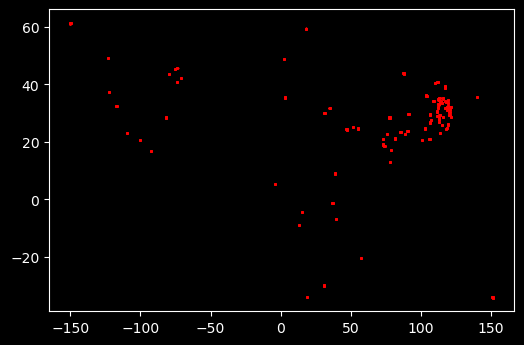

In [16]:
plot_cluster(X)